# Nadaraya-Watson 核回归

卷积，全连接，池化层学习的是**不随意线索**，即，对于给定的输入，被动的，整体的，不加过滤的学习输入数据的全部特征，这样可能导致一些不重要的，但反复出现的特征被模型当作重要的特征进行学习，导致最终的学习结果与真实数据发生偏差
而注意力机制则希望有偏向性的选择某些输入，因此希望考虑**随意线索**，即模型决定有比重的学习输入的不同特征  
* 随意线索称为**查询（query）**  
* 每个输入是一个**值（value）** 和 **不随意线索（key）** 组成的对  
* 通过注意力池化层来有偏向幸的选择某些输入

<img src="Attention_Greneral.png" width=500px>




### 非参注意力池化层

非参：没有需要学习的参数  
有数据$(x_i,y_i), i = 1, \cdots ,n$  
这里$x_i$可以理解为输入的数据（向量，tensor），而$y_i$是$x_i$所对应的输出，或者说是标签  
如果我们进行平均池化操作（注意，这和cnn池化层的操作不同）：$f(x) = \frac{1}{n} \sum_i y_i$  
这样的池化操作本质上就是对无论哪个输入x，输出的都是所有y的平均值，因此是最简单的预测，不考虑输入$x$与已知输入$x_i$的关系
Nadaraya-Watson回归考虑的问题是，对于一个新的输入$x$，需要考虑它和所有已知的$x_i$的关系，或者说占所有已知$x_i$权重，对于权重更高的输入，相应的标签$y$的权重也应该更大：
$$
f(x) = \sum_{i=1}^{n}\frac{K(x - x_i)}{\sum_{j = 1}^{n}K(x - x_j)}y_i
$$
在Nadaraya-Watson核回归中，我们的输入x即为注意力池化层中所说的`query`，可以理解为我们希望去**查询**的值，  
而`key`对应的就是我们已知的输入`x_i`  
相应的，`value`所对应的是公式中的每一个已知`x_i`对应的输出$y_i$  
`K`是一个函数，用来衡量`x`与`x_i`的距离，可以理解为$K(x - x_i)$越大，$x$与$x_i$的距离越小，$\frac{K(x - x_i)}{\sum_{j = 1}^{n}K(x - x_j)}$，这一整个就相当于是求出所占的比例、权重  
整行公式可以理解为，对于一个新的输入`x`，我们希望去将`x`与我们所有已知的`key`进行比较，将距离`x`越近的那些`key`所对应的`value`找出来做加权来得出最终对`x`的预测，这样得到的预测理论上会比前面的简单的平均池化得到的结果准确的多。  


公式中的`K`即为核（kernel），选取不同的K会得到不同的结果。  
令$u= x - x_i$  
选取高斯核$K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})$  
带入核回归公式中可以得到：  

$$
\begin{align*}

f(x) 
&= \sum_{i=1}^{n}\frac{\frac{1}{\sqrt{2\pi}}exp(-\frac{(x - x_i)^2}{2})}{\sum_{j = 1}^{n}\frac{1}{\sqrt{2\pi}}exp(-\frac{(x - x_i)^2}{2})}y_i \\
& = \sum_{i=1}^{n}\frac{exp(-\frac{(x - x_i)^2}{2})}{\sum_{j = 1}^{n}exp(-\frac{(x - x_i)^2}{2})}y_i

\end{align*}
$$
由化简的结果，我们很自然地联想到$softmax$函数:
$$
\hat y = softmax(o)\\
\hat y_i = \frac{exp(o_i)}{\sum_k exp(o_k)}
$$
因此，如果用softmax替换就可以得到：
$$
\begin{align*}
f(x)  = \sum_{i=1}^{n}softmax(-\frac{(x - x_i)^2}{2})y_i
\end{align*}
$$

### 参数化注意力机制
在此基础上，引入可以学习的参数$w$：
$$
\begin{align*}
f(x)  = \sum_{i=1}^{n}softmax(-\frac{((x - x_i)w)^2}{2})y_i
\end{align*}
$$
就是参数化的注意力机制

In [2]:
import torch 
import math
from torch import nn
from d2l import torch as d2l

In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
    ##注意这里(n_train,)的逗号不能省略，省略后(n_train)变成是int类型，不符合要求
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

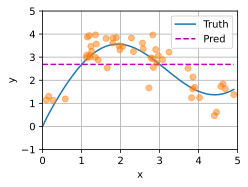

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend = ['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [21]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
print(X_repeat.shape)

torch.Size([50, 50])


这行代码`repeat_interleave(n_train)`函数将x_test中的每一个元素连续重复`n_train`次，并且拉长成一个一维向量，然后再将这个一维向量`reshape`成`n_train`列的矩阵，目的是为了后面实现计算$(x - x_i)^2$做准备，因为根据前面的代码，我们已知的数据，也就是$x_i$共有`n_train`个

In [22]:
print(x_train.shape)
print((X_repeat - x_train).shape)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim = 1)
attention_weights.shape

torch.Size([50])
torch.Size([50, 50])


torch.Size([50, 50])

这行代码就是用来计算注意力权重的，相当于公式中的$softmax(-\frac{((x - x_i)w)^2}{2})$这整个部分。其中`-(X_repeat - x_train)**2 / 2`利用了python的广播机制，将`X_repreat`的每一行的每一个数都与`x_train`做减法，然后再平方取负除以二，最后指定`dim=1`，用来对每一行使用softmax函数求出最后的注意力分数。

In [ ]:
t_train = 3
m_train = torch.tensor([3, 6, 9])
m_test = torch.tensor([5, 10, 15, 20])
M_repeat = m_test.repeat_interleave(t_train).reshape((-1,t_train))
print(M_repeat)
print(M_repeat.shape)
m_attention_weights = nn.functional.softmax(-(M_repeat - m_train)**2 / 2, dim = 1)
print(m_attention_weights.shape)

tensor([[ 5,  5,  5],
        [10, 10, 10],
        [15, 15, 15],
        [20, 20, 20]])
tensor([[1.8234e-01, 8.1720e-01, 4.5198e-04],
        [3.7730e-11, 5.5278e-04, 9.9945e-01],
        [3.5326e-24, 1.6919e-10, 1.0000e+00],
        [3.3057e-37, 5.1756e-17, 1.0000e+00]])


下面用一个简单的例子解释这整个过程：
假设`n_train = 3`,`x_test = [5,10,15,20]`, `x_train  = [3, 6, 9]`,`y_train = [0, 1, 2]`  
这个例子之所以简单，是因为每一个样本只有一个特征，即每一个y只有一个x作为参数，因此这里的x_test就相当于是有四个query，需要对每一个query求出相应的核函数值  
则经过`repeat_interleave(n_train)`后，`x_test = [5, 5, 5, 10, 10, 10, 15, 15, 15, 20, 20, 20]`，然后reshape成：  
```python
tensor([[ 5,  5,  5],
        [10, 10, 10],
        [15, 15, 15],
        [20, 20, 20]])
```
计算`softmax(-(M_repeat - m_train)**2 / 2, dim = 1)`得到：
```python
tensor([[1.8234e-01, 8.1720e-01, 4.5198e-04],
        [3.7730e-11, 5.5278e-04, 9.9945e-01],
        [3.5326e-24, 1.6919e-10, 1.0000e+00],
        [3.3057e-37, 5.1756e-17, 1.0000e+00]])
```
如果用距离来理解，这样每一行就相当于是一个输入距离各个样本的相对距离，数字越大代表距离越近。

In [19]:
y_hat = torch.matmul(attention_weights, y_train)

最后，根据公式，对于注意力权重矩阵，只需要和y_train进行矩阵乘法，即可求得最终的预测值。

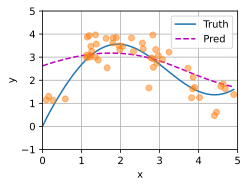

In [ ]:
plot_kernel_reg(y_hat)

可以发现，用这种方法求出的预测值已经有了和原函数大致相同的趋势，只是由于softmax回归，整个预测曲线较为平缓。